## <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea">Assignment 5: Credit Card Users Churn Prediction</span>

&nbsp;

<p align="center" style="font-family: Arial;color:#0e92ea;font-size:1em;">
The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances. Goal is to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards
</p>

##  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> Contents:</span>

<ol style="font-family: Arial;color:#0e92ea;font-size:1em;">
    <li>Exploratory Data Analysis and Insights</li>
    <li>Data pre-processing</li>
    <li>Model building</li>
    <li>Model building - Oversampled data</li>
    <li>Model building - Undersampled data</li>
    <li>Hyperparameter tuning using random search</li>
    <li>Model Performances</li>
    <li>Productionize the model</li>
    <li>Recommendations</li>
</ol>

In [1]:
'''
pip install category_encoders
pip install xgboost
'''

'\npip install category_encoders\npip install xgboost\n'

In [2]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

from sklearn.base import BaseEstimator

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")
base_data = pd.read_csv('BankChurners.csv')

default_color_palette  = ["#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"]
maritalstatus_color_palette = {'Single':'#ff3d00', 'Married':'#00c853', 'Divorced': '#EA112F'}
stats_colors           = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'} # Set standard colors for mean, mode and median to use accross entire notebook.
gender_color_palette   = {"F":"#E91E63", "M":"#42A5F5"} # Gender based colors.

####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 1 and 2: Exploratory Data Analysis and Insights and Data Processing

In [3]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    nulls_series      = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    nonnulls_series   = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    nulls_percentage  = ((nulls_series * 100)/(nulls_series + nonnulls_series)).astype(float)
    column_datatypes  = dataFrame.dtypes               # Get a series containing data types for each column 
    
    series_arr    = [nulls_series, nonnulls_series, nulls_percentage, column_datatypes]
    col_names_arr = ["Nulls", "Non-Nulls","Nulls %", "Type"]
    
    nulls_count_df = pd.concat(
        objs = series_arr,
        axis = 1,
        keys = col_names_arr, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(nulls_count_df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, ['Nulls %']]).format(formatter={('Nulls %'): "{:.2f}%"})) 
    

'''
Input:
Target type and a list of feature names.

Output:
Convert all features provided in 'column_names' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def ConvertColTo(toType = "category", column_names=np.nan, df = np.nan):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(toType)


'''
Input:
N/A

Output:
Go through each categorial column and print unique values for that column.

Retunrs:
N/A
'''
def CountUniqueValues(col_names):
    for col_name in col_names:
        print(f"======================='{col_name}'==================")
        for unique_col_value in  main_data[col_name].unique().tolist():
            total_count = main_data[col_name].count()
            unique_values_count = main_data[main_data[col_name] == unique_col_value][col_name].count()
            percentage = str(round((unique_values_count/total_count) * 100, 2))
            print(f"{unique_col_value} \t: {unique_values_count} ({percentage}%)")
        print(f"=========================================================\n")
        
'''
Input:
list of column names

Output:
a dictionary contating coloumn with unique value counts
split by thhe threshold

Retunrs:
N/A
'''
def SplitColumnsByUniqueValueCountThreshold(col_names, threshold = 30):
    results = {
        'lower_set' : [],
        'upper_set': []
    }
    
    for col_name in col_names:            
        if len(list(main_data[col_name].unique())) < threshold:
            results['lower_set'].append(col_name)
        else:
            results['upper_set'].append(col_name)
            
    pprint.pprint(results)
    return results

'''
Description:
Given the model the test data y values, displays the confusion matrix for that model.

Input:
model    - The learning model.
y_actual - Y values from test data.
labels   - the labels

Returns:
N/A
'''
def DisplayConfusionMatrix(model, y_actual, labels=[1,0]):
    y_predict             = model.predict(x_test)
    confusion_matrix      = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    
    confusion_matix_df = pd.DataFrame(
        data    = confusion_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts     = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (10,7))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

'''
Description:
Given the model, computes models perfomance on test and training data.
Perf metrics displayed are: Accuracy, Recall, F1 Score, and precision.

Input:
model - The learning model.

Returns:
A dictionary containing models perfomace.
'''
def GetMetricsScore(model, x_train_arg, x_test_arg, y_train_arg, y_test_arg):
    
    pred_train = model.predict(x_train_arg)
    pred_test  = model.predict(x_test_arg)
    
    train_accuracy = model.score(x_train_arg, y_train_arg)
    test_accuracy  = model.score(x_test_arg, y_test_arg)
    
    train_recall = metrics.recall_score(y_train_arg, pred_train)
    test_recall  = metrics.recall_score(y_test_arg, pred_test)
    
    train_precision = metrics.precision_score(y_train_arg, pred_train)
    test_precision  = metrics.precision_score(y_test_arg, pred_test)

    f1_score_train = 2 * ((train_precision * train_recall)/(train_precision + train_recall))
    f1_score_test = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
    
    return {
        'Accuracy_Test'   : test_accuracy,
        'Accuracy_Train'  : train_accuracy,
        'Recall_Test'     : test_recall,
        'Recall_Train'    : train_recall,
        'Precision_Test'  : test_precision,
        'Precision_Train' : train_precision,
        'F1_Score_Train'  : f1_score_train,
        'F1_Score_Test'   : f1_score_test
    }
        
'''
Description:
Given the model, displays the importance score.

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayImportanceScores(model):
    gini_importances = pd.DataFrame(
        data    = model.feature_importances_, 
        columns = ["Imp"],
        index   = x_train.columns).sort_values(by = "Imp")
    
    print(gini_importances)

'''
Description:
Given the model, displays the importance chart.

Input:
model    - The learning model.

Returns:
N/A
'''
def DisplayImportanceChart(model):
    importances = model.feature_importances_
    indices     = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [list(X.columns)[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

'''
Description:
Given the decision tree model, displays the decision tree of that model.

Input:
model - The learning model.
size  - Size of the plot

Returns:
N/A
'''
def PlotDecisionTree(model, size= [20, 30]):
    plt.figure(figsize=(size[0],size[1]))
    tree.plot_tree(
        model, 
        feature_names=feature_names,
        filled=True,
        fontsize=9,
        node_ids=True,
        class_names=True)
    plt.show()
 
'''
Description:
Given a model, displays the coefient values of that model

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayCoeficients(model):
    coefs = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=x_train.columns.tolist() + ["Intercept"],
        columns=["Coefficients"],
    )

    coefs.sort_values('Coefficients')

### Data Exploration

In [4]:
base_data.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,810347208,Existing Customer,51,M,4,NaN,Married,$120K +,Gold,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,818906208,Existing Customer,32,M,0,High School,NaN,$60K - $80K,Silver,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


In [5]:
TARGET_COLUMN = 'Attrition_Flag'

In [6]:
info(base_data)

10127 Rows x 21 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
CLIENTNUM,0,10127,0.00%,int64
Card_Category,0,10127,0.00%,object
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,1519,8608,15.00%,object


In [7]:
base_data.drop("CLIENTNUM", axis=1, inplace=True)

In [8]:
replace_struct = {
    "Attrition_Flag" : {"Existing Customer": 0, "Attrited Customer": 1},
}
base_data = base_data.replace(replace_struct)
base_data[TARGET_COLUMN] = pd.to_numeric(base_data[TARGET_COLUMN], downcast="integer")

In [9]:
# Separating data into X and Y
X = base_data.drop([TARGET_COLUMN], axis = 1)
Y = base_data[TARGET_COLUMN]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

print(x_train.shape, x_test.shape)

(5063, 19) (5064, 19)


In [10]:
main_data = pd.concat([x_train, y_train], axis=1)

In [11]:
main_data.head(10)

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
4044,54,M,2,Post-Graduate,Single,$120K +,Blue,45,3,1,4,5597.0,0,5597.0,0.596,4844,58,0.871,0.000,0
3777,49,F,4,Uneducated,NaN,abc,Blue,39,5,2,3,11545.0,1732,9813.0,0.871,3996,65,0.548,0.150,0
1878,45,M,2,College,Divorced,$80K - $120K,Blue,39,3,4,4,34516.0,0,34516.0,1.014,1041,27,0.350,0.000,1
6933,42,M,4,High School,Single,$80K - $120K,Blue,28,3,3,3,1944.0,1804,140.0,0.723,4682,90,0.667,0.928,0
6218,40,F,4,Graduate,Single,Less than $40K,Blue,25,4,2,3,1438.3,0,1438.3,0.628,2493,42,0.500,0.000,1
719,39,M,2,Uneducated,Single,$40K - $60K,Blue,32,6,3,2,7723.0,1902,5821.0,1.181,1241,22,1.000,0.246,0
1175,36,F,2,Post-Graduate,Married,Less than $40K,Blue,25,5,3,4,4701.0,1492,3209.0,0.805,1679,32,0.455,0.317,0
4712,51,M,2,Graduate,Divorced,$60K - $80K,Blue,41,4,3,1,1959.0,0,1959.0,0.454,3737,71,0.614,0.000,0
3876,48,M,4,Post-Graduate,Single,$120K +,Blue,38,5,2,0,34516.0,1639,32877.0,0.688,4959,74,0.805,0.047,0
777,54,M,4,Graduate,Married,$120K +,Blue,50,4,2,0,2872.0,2035,837.0,0.613,1770,47,0.741,0.709,0


### Missing Values Treatment

In [12]:
catgry_col_names = main_data.select_dtypes(include=['object']).columns.tolist()

In [13]:
ConvertColTo('category', catgry_col_names, main_data)
info(main_data)

5063 Rows x 20 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,5063,0.00%,int8
Avg_Open_To_Buy,0,5063,0.00%,float64
Avg_Utilization_Ratio,0,5063,0.00%,float64
Card_Category,0,5063,0.00%,category
Contacts_Count_12_mon,0,5063,0.00%,int64
Credit_Limit,0,5063,0.00%,float64
Customer_Age,0,5063,0.00%,int64
Dependent_count,0,5063,0.00%,int64
Education_Level,730,4333,14.42%,category
Gender,0,5063,0.00%,category


In [14]:
catgry_col_names = main_data.select_dtypes(include=['category']).columns.tolist()
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 2379 (46.99%)
F 	: 2684 (53.01%)

======================='Education_Level'==================
Post-Graduate 	: 261 (6.02%)
Uneducated 	: 765 (17.66%)
College 	: 522 (12.05%)
High School 	: 992 (22.89%)
Graduate 	: 1574 (36.33%)
nan 	: 0 (0.0%)
Doctorate 	: 219 (5.05%)

======================='Marital_Status'==================
Single 	: 1945 (41.42%)
nan 	: 0 (0.0%)
Divorced 	: 384 (8.18%)
Married 	: 2367 (50.4%)

======================='Income_Category'==================
$120K + 	: 352 (6.95%)
abc 	: 576 (11.38%)
$80K - $120K 	: 784 (15.48%)
Less than $40K 	: 1764 (34.84%)
$40K - $60K 	: 886 (17.5%)
$60K - $80K 	: 701 (13.85%)

======================='Card_Category'==================
Blue 	: 4713 (93.09%)
Silver 	: 279 (5.51%)
Platinum 	: 13 (0.26%)
Gold 	: 58 (1.15%)



In [15]:
def MissingValuesTreatment(df):
    df['Education_Level'].fillna(df['Education_Level'].value_counts().idxmax(), inplace=True)
    df['Marital_Status'].fillna(df['Marital_Status'].value_counts().idxmax(), inplace=True)
    
MissingValuesTreatment(main_data)

In [16]:
info(main_data)

5063 Rows x 20 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,5063,0.00%,int8
Avg_Open_To_Buy,0,5063,0.00%,float64
Avg_Utilization_Ratio,0,5063,0.00%,float64
Card_Category,0,5063,0.00%,category
Contacts_Count_12_mon,0,5063,0.00%,int64
Credit_Limit,0,5063,0.00%,float64
Customer_Age,0,5063,0.00%,int64
Dependent_count,0,5063,0.00%,int64
Education_Level,0,5063,0.00%,category
Gender,0,5063,0.00%,category


In [17]:
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 2379 (46.99%)
F 	: 2684 (53.01%)

======================='Education_Level'==================
Post-Graduate 	: 261 (5.16%)
Uneducated 	: 765 (15.11%)
College 	: 522 (10.31%)
High School 	: 992 (19.59%)
Graduate 	: 2304 (45.51%)
Doctorate 	: 219 (4.33%)

======================='Marital_Status'==================
Single 	: 1945 (38.42%)
Married 	: 2734 (54.0%)
Divorced 	: 384 (7.58%)

======================='Income_Category'==================
$120K + 	: 352 (6.95%)
abc 	: 576 (11.38%)
$80K - $120K 	: 784 (15.48%)
Less than $40K 	: 1764 (34.84%)
$40K - $60K 	: 886 (17.5%)
$60K - $80K 	: 701 (13.85%)

======================='Card_Category'==================
Blue 	: 4713 (93.09%)
Silver 	: 279 (5.51%)
Platinum 	: 13 (0.26%)
Gold 	: 58 (1.15%)



In [18]:
        
'''
Description:
Displays a grid catplots

Input:
A list of column names
'''
def DisplayCountPlotGrid(col_names, hue_name, color_palette):
    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, axs = plt.subplots(
            nrows=1,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                column_name = col_names[col_index]
                ax = axs.flat[index]
                ax = sns.countplot(
                    data=main_data,
                    x=main_data[column_name],
                    palette=color_palette,
                    hue=hue_name,
                    ax = ax)
                ax.set_xlabel(column_name)                                           
                ax.set_title(column_name + ' and '+ hue_name +' Profile', fontsize=14)
                if int(len(ax.get_xticklabels())) > 14: 
                    ax.set_xticklabels([], rotation=45, ha='right')
                else:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            col_index += 1
            
'''
Input:
N/A

Output:
Plot box plots in line.

Returns:
N/A
'''     
def PlotLineOfCountPlots(col_names, hue_name, palette_name):
    fig, axs = plt.subplots(
        len(col_names),
        figsize = (15,6),
        sharex  = False,
        sharey  = False)
    
    fig.subplots_adjust(top = 4)
    
    for i in range(len(col_names)):
        column_name = col_names[i]
        sns.countplot(
            data    = main_data, 
            x       = column_name,
            hue     = hue_name,
            palette = palette_name,
            ax      = axs[i])
        
        axs[i].set_xlabel(column_name)                                           
        axs[i].set_title(column_name + ' Profile', fontsize=14)
        
        if int(len(axs[i].get_xticklabels())) > 30: 
            axs[i].set_xticklabels([], rotation=45, ha='right')
        else:
            axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [19]:
cols_dic = SplitColumnsByUniqueValueCountThreshold(
    main_data.select_dtypes(include=['float', 'int64']).columns.tolist(),
    40)
descrete_data_columns        = cols_dic['lower_set']
large_descrete_data_columns  = cols_dic['upper_set']

{'lower_set': ['Dependent_count',
               'Total_Relationship_Count',
               'Months_Inactive_12_mon',
               'Contacts_Count_12_mon'],
 'upper_set': ['Customer_Age',
               'Months_on_book',
               'Credit_Limit',
               'Total_Revolving_Bal',
               'Avg_Open_To_Buy',
               'Total_Amt_Chng_Q4_Q1',
               'Total_Trans_Amt',
               'Total_Trans_Ct',
               'Total_Ct_Chng_Q4_Q1',
               'Avg_Utilization_Ratio']}


In [20]:
large_descrete_data_columns

['Customer_Age',
 'Months_on_book',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [21]:
descrete_data_columns

['Dependent_count',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon']

### Exploring Univariate and Bivariate Analysis based on Gender
- The number of clients is higher in customers who are Graduates
- The number of clients is higher in customers who are Married and Single
- The number of clients is higher in customers who earn less that $40k per year
- Blue card has the highest number of clients and seems to be the one brining in more money

In [22]:
catgry_col_names.append(TARGET_COLUMN)
print(catgry_col_names)

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag']


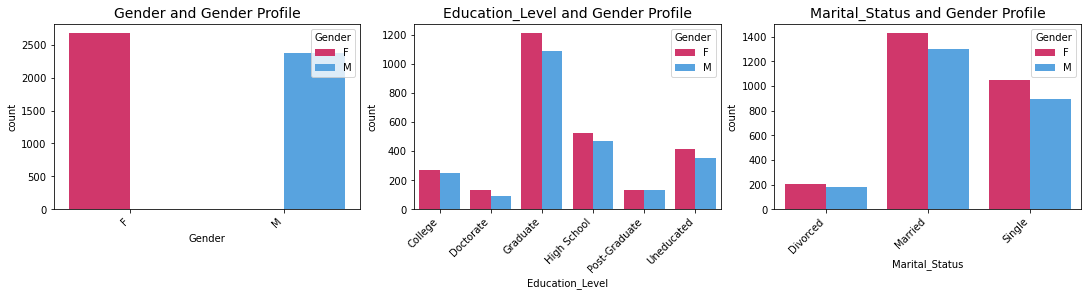

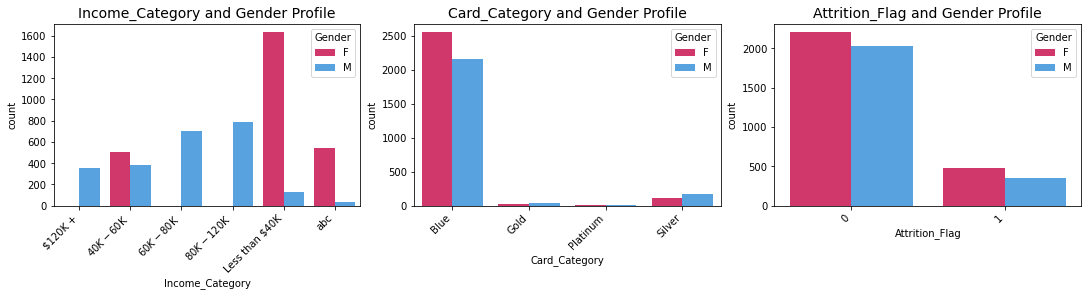

In [23]:
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Gender",
    color_palette = gender_color_palette)

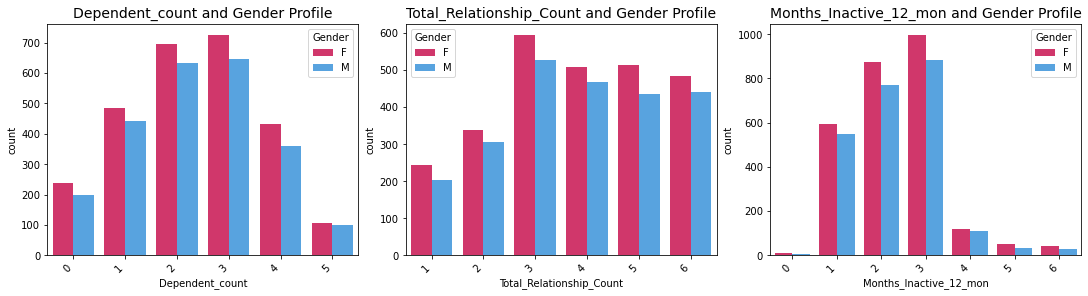

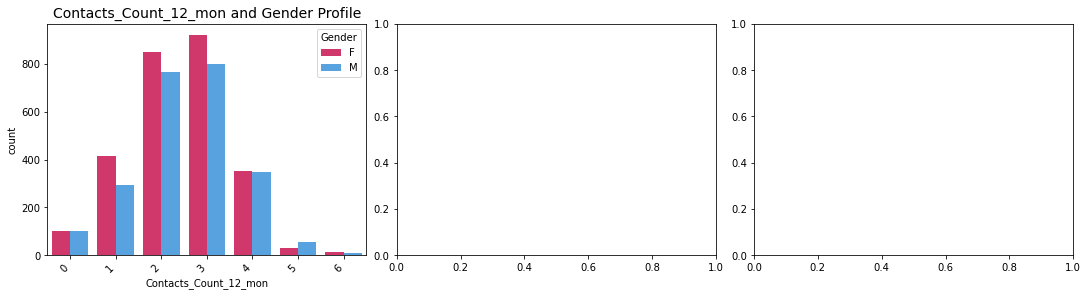

In [24]:
DisplayCountPlotGrid(
    col_names    = descrete_data_columns,
    hue_name     = "Gender",
    color_palette = gender_color_palette)

### Exploring Univariate and Bivariate Analysis based on  Marital Status
- The charts sho a higher number of clients who are married and single
- Also the ratio of clients who left the service based on marital statis seems insignificance. Cannot deduce from the current of the data who category is most likely to stay or leave.
- Another noticeable difference is how dominant maried category is.
- Also most of the customers seems to be having a 2-3 dependents 

In [25]:
CountUniqueValues(['Marital_Status'])

======================='Marital_Status'==================
Single 	: 1945 (38.42%)
Married 	: 2734 (54.0%)
Divorced 	: 384 (7.58%)



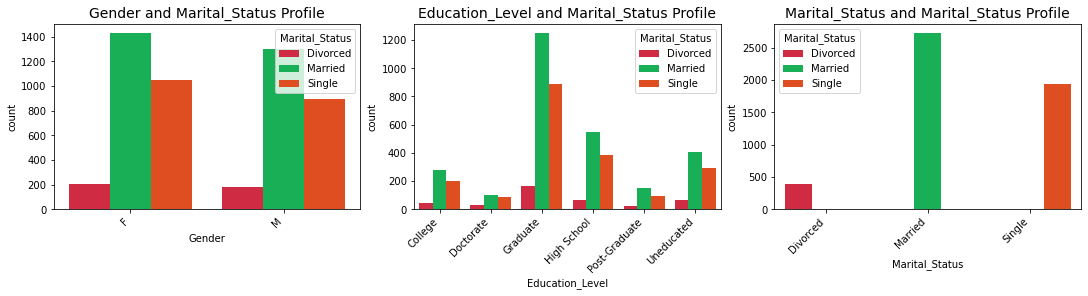

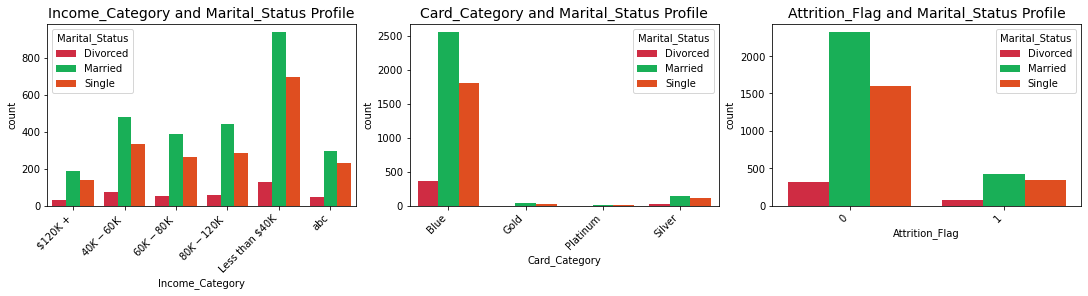

In [26]:
DisplayCountPlotGrid(
    col_names    = catgry_col_names,
    hue_name     = "Marital_Status",
    color_palette = maritalstatus_color_palette)

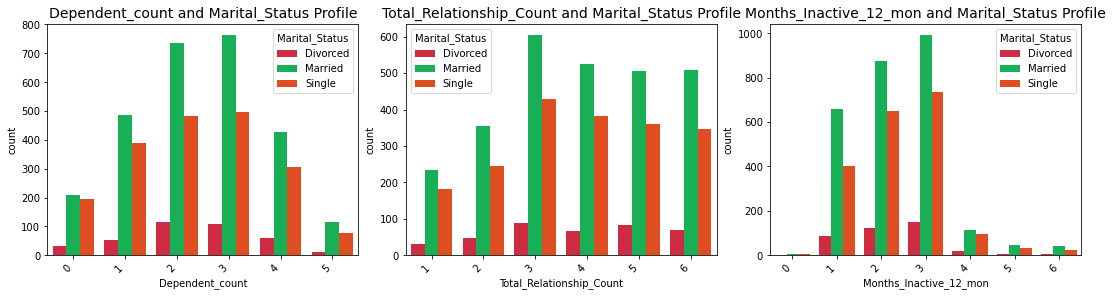

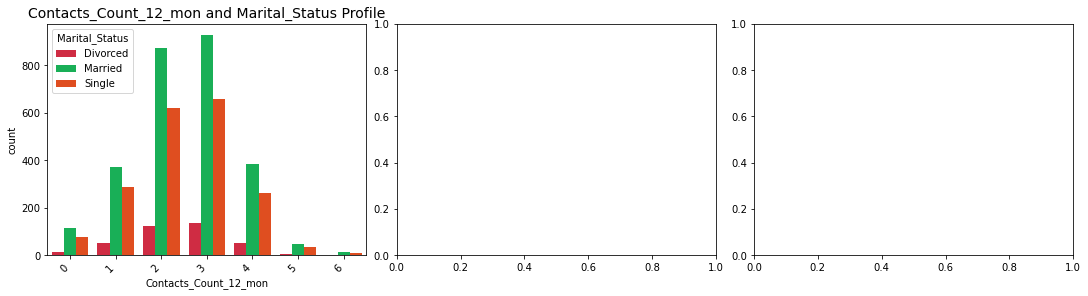

In [27]:
DisplayCountPlotGrid(
    col_names       = descrete_data_columns,
    hue_name        = "Marital_Status",
    color_palette   = maritalstatus_color_palette)

### Exploring Univariate and Bivariate Analysis based on Education
- Not that much noticeable differen except that most of the customers are graduates and they are also the ones most likely to leave the service

In [28]:
CountUniqueValues(['Education_Level'])

======================='Education_Level'==================
Post-Graduate 	: 261 (5.16%)
Uneducated 	: 765 (15.11%)
College 	: 522 (10.31%)
High School 	: 992 (19.59%)
Graduate 	: 2304 (45.51%)
Doctorate 	: 219 (4.33%)



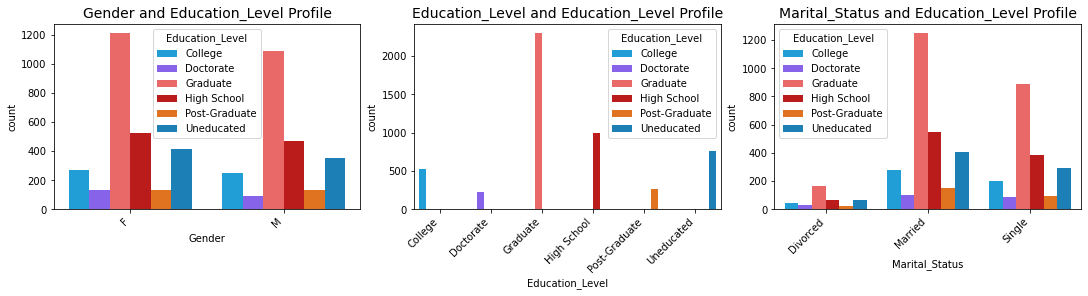

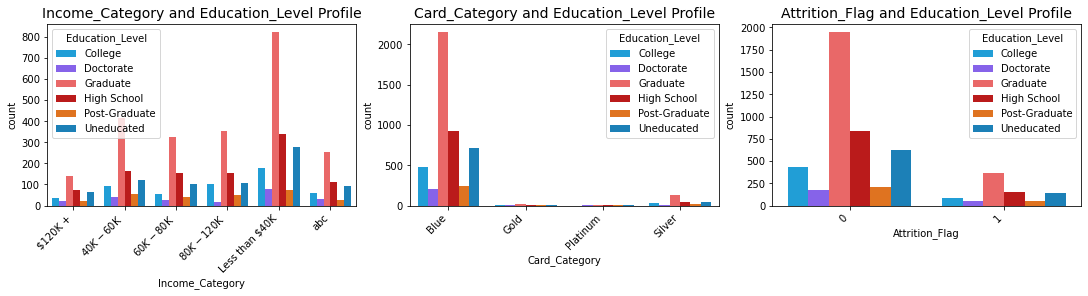

In [29]:
DisplayCountPlotGrid(
    col_names    = catgry_col_names,
    hue_name     = "Education_Level",
    color_palette = default_color_palette)

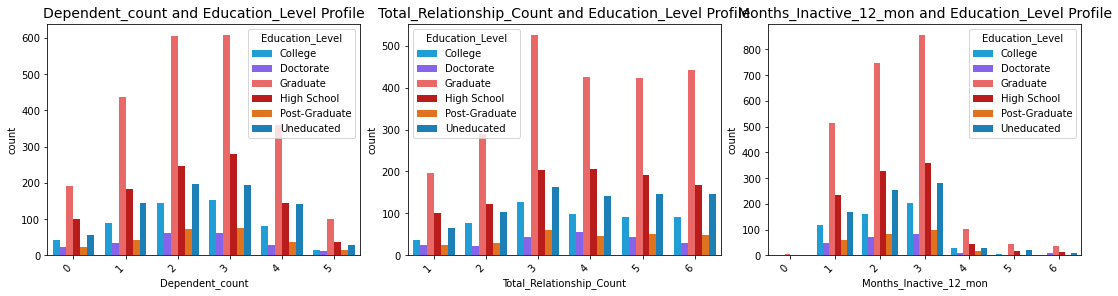

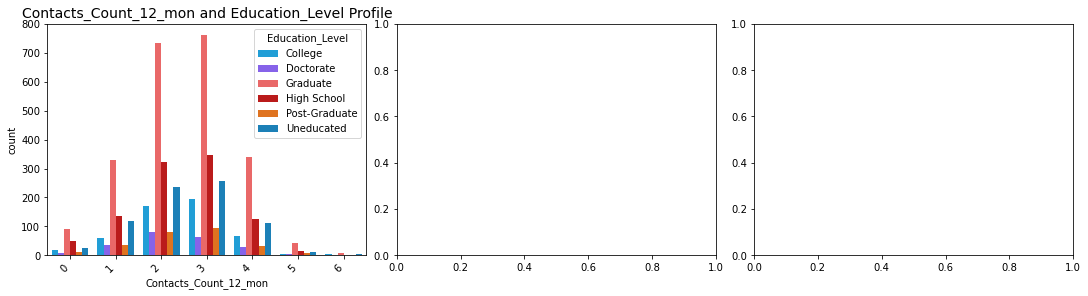

In [30]:
DisplayCountPlotGrid(
    col_names       = descrete_data_columns,
    hue_name        = "Education_Level",
    color_palette   = default_color_palette)

### Exploring Univariate and Bivariate Analysis based on Card Type
- Again we see blue as the most dominant card in all categories.
- This blue card is also the one with the highest number of attrited customers.
- There is also a higher number of customers using the blue card who are earning less than $40k per year.

In [31]:
CountUniqueValues(['Card_Category'])

======================='Card_Category'==================
Blue 	: 4713 (93.09%)
Silver 	: 279 (5.51%)
Platinum 	: 13 (0.26%)
Gold 	: 58 (1.15%)



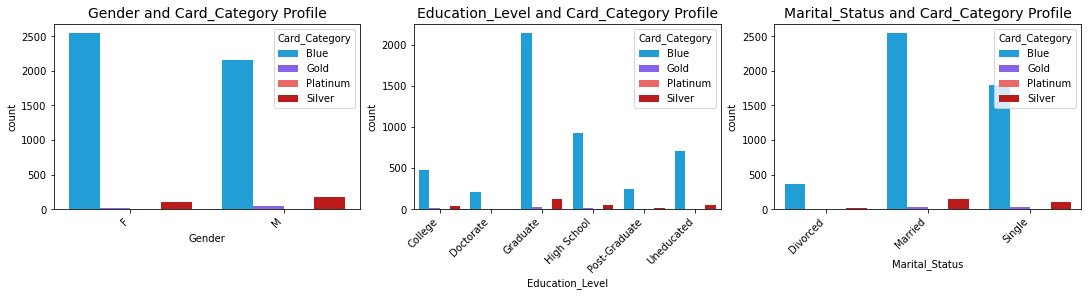

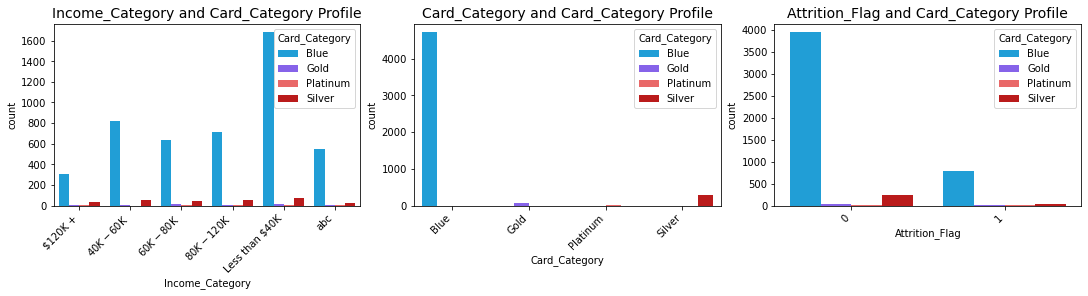

In [32]:
DisplayCountPlotGrid(
    col_names    = catgry_col_names,
    hue_name     = "Card_Category",
    color_palette = default_color_palette)

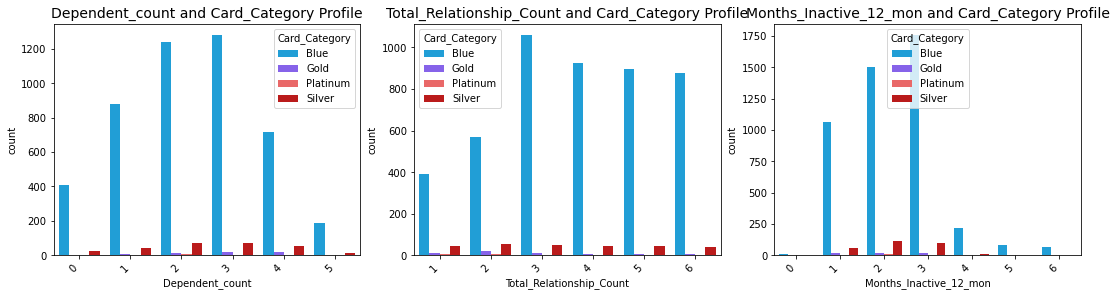

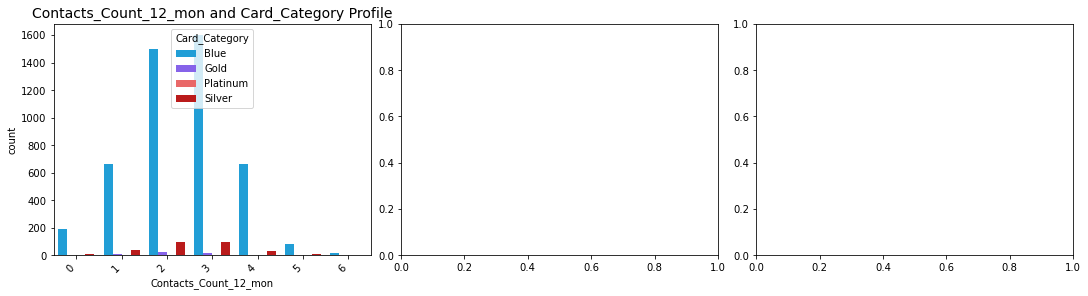

In [33]:
DisplayCountPlotGrid(
    col_names       = descrete_data_columns,
    hue_name        = "Card_Category",
    color_palette   = default_color_palette)

### Exploring Univariate and Bivariate Analysis based on Income
- We notice a spike or peak values in customers who are earning less than \$40k per year
- The number of people leaving the credit card service based on income seems level or average accross all categories except for customers who are earning less than \$40k per year with the highest number of attrition
- Customers who earn less than \$40k per year also have 2-3 dependants

In [34]:
CountUniqueValues(['Income_Category'])

======================='Income_Category'==================
$120K + 	: 352 (6.95%)
abc 	: 576 (11.38%)
$80K - $120K 	: 784 (15.48%)
Less than $40K 	: 1764 (34.84%)
$40K - $60K 	: 886 (17.5%)
$60K - $80K 	: 701 (13.85%)



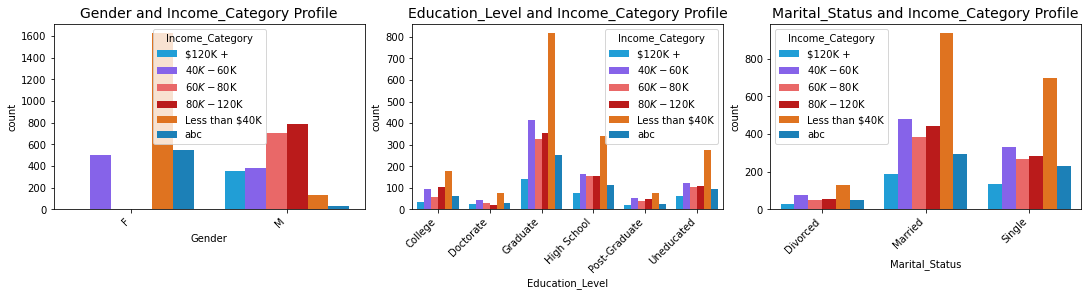

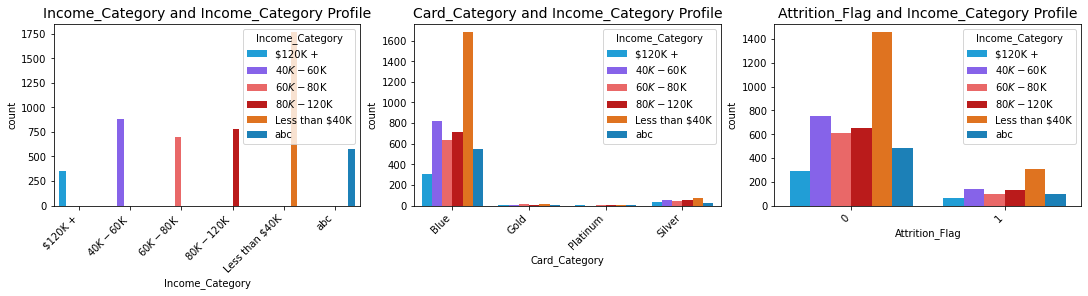

In [35]:
DisplayCountPlotGrid(
    col_names    = catgry_col_names,
    hue_name     = "Income_Category",
    color_palette = default_color_palette)

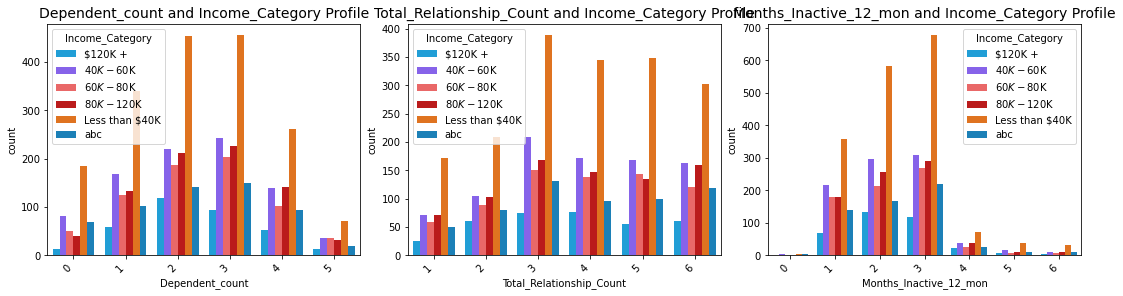

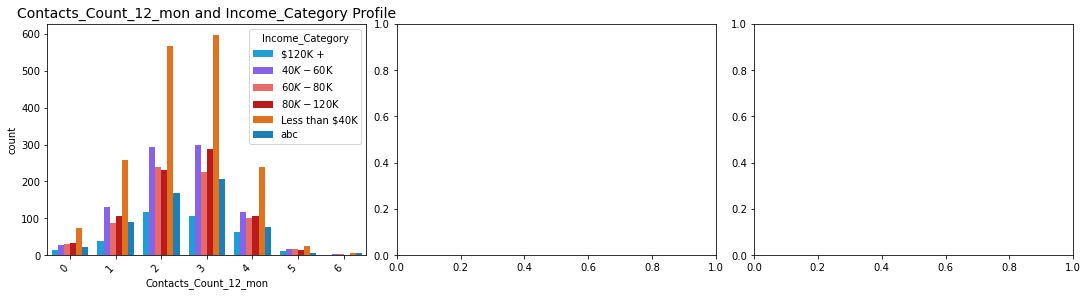

In [36]:
DisplayCountPlotGrid(
    col_names       = descrete_data_columns,
    hue_name        = "Income_Category",
    color_palette   = default_color_palette)

### Data Processing and Feature engineering

In [37]:
def ColumnTransformation(df):
    replace_struct = {
        "Card_Category"       : {"Blue": 1, "Silver": 2, "good": 3, "Gold": 4, "Platinum": 5},
        "Income_Category"     : {"abc": -1, "Less than $40K": 1, "$40K - $60K": 2, "$60K - $80K": 3, "$80K - $120K": 4, "$120K +": 5},
        "Education_Level"     : {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4, "Post-Graduate":5, "Doctorate": 6},
        "Attrition_Flag"      : {"Existing Customer": 0, "Attrited Customer": 1},
    }

    df = df.replace(replace_struct)
    df.head(10)
    return df
    
main_data = ColumnTransformation(main_data)

In [38]:
def OneHotEncoding(df):
    oneHotCols = ["Gender", "Marital_Status"]
    df = pd.get_dummies(df, columns=oneHotCols)
    info(df)
    return df

main_data = OneHotEncoding(main_data)

5063 Rows x 23 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,5063,0.00%,int8
Avg_Open_To_Buy,0,5063,0.00%,float64
Avg_Utilization_Ratio,0,5063,0.00%,float64
Card_Category,0,5063,0.00%,int64
Contacts_Count_12_mon,0,5063,0.00%,int64
Credit_Limit,0,5063,0.00%,float64
Customer_Age,0,5063,0.00%,int64
Dependent_count,0,5063,0.00%,int64
Education_Level,0,5063,0.00%,int64
Gender_F,0,5063,0.00%,uint8


In [39]:
def FixTargetFeatureType(df):
    df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], downcast="integer")
    return df
    
main_data = FixTargetFeatureType(main_data)

In [40]:
info(main_data)

5063 Rows x 23 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,5063,0.00%,int8
Avg_Open_To_Buy,0,5063,0.00%,float64
Avg_Utilization_Ratio,0,5063,0.00%,float64
Card_Category,0,5063,0.00%,int64
Contacts_Count_12_mon,0,5063,0.00%,int64
Credit_Limit,0,5063,0.00%,float64
Customer_Age,0,5063,0.00%,int64
Dependent_count,0,5063,0.00%,int64
Education_Level,0,5063,0.00%,int64
Gender_F,0,5063,0.00%,uint8


### Corrolation and Skewness

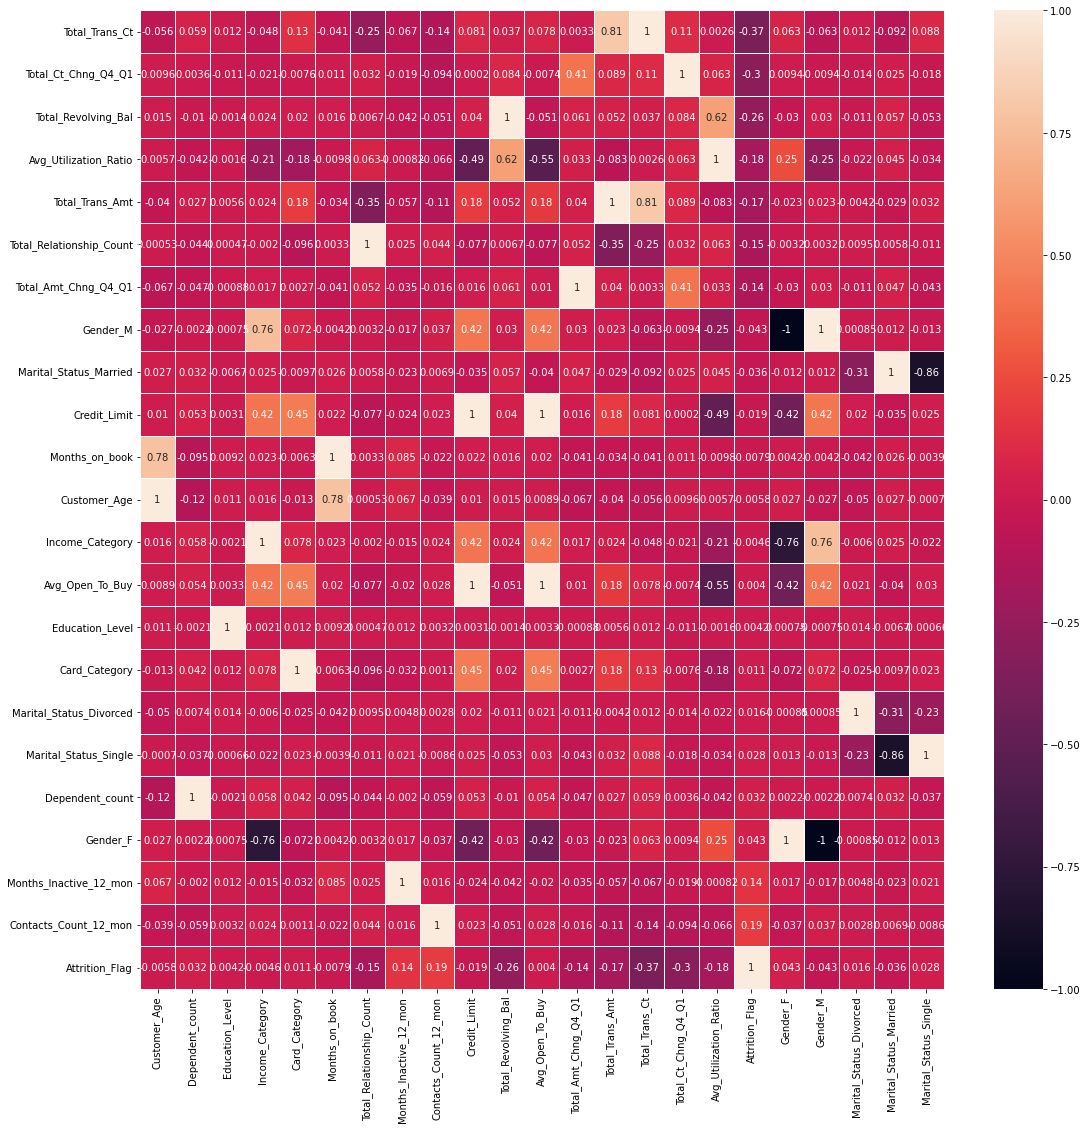

In [41]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=main_data.corr().sort_values(by=[TARGET_COLUMN]), annot=True, linewidths=.5, ax=ax)
plt.show()

In [42]:
'''
Input:
Axis, column name/x-axis, hue name

Output:
Displays a count plot.

Retunrs:
N/A
''' 
def HistBoxplot(box_chart_ax, hist_chart_ax, x_axis):
    sns.boxplot(
        data=main_data,
        x=main_data[x_axis],
        showmeans=True,
        ax=box_chart_ax)
    
    sns.histplot(
        data=main_data,
        x=main_data[x_axis],
        kde=True,
        ax=hist_chart_ax)
    
    hist_chart_ax.axvline(main_data[x_axis].mean(),                 # Get the mean of the values in the given column and draw a vertical line that cuts the chart on the mean value 
               color=stats_colors['Mean'],                                  # Use on of the colors predefined on this notebook
               label='Mean',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].median(),               # Plot the median line on the chart.
               color=stats_colors['Median'],                                # Use on of the colors predefined on this notebook
               label='Median',                                              # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].mode()[0],              # Plot the mode line on the chart.
               color=stats_colors['Mode'],                                  # Use on of the colors predefined on this notebook 
               label='Mode',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.legend(loc='upper right')

'''
Input:
N/A

Output:
Displays a a grid of [Boxplot x Distribution chart] for discrete features.

Returns:
N/A
''' 
def PlotHistBoxGrid():
    col_names = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    print(col_names)

    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, (box, hist) = plt.subplots(
            nrows=2,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            gridspec_kw={"height_ratios" : (0.25,0.5)},
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                HistBoxplot(box.flat[index], hist.flat[index], col_names[col_index])
            col_index += 1

In [43]:
'''
Input:
Column name

Output:
A series containing interquatile range values

Retunrs:
A dictionary containing quatile range values
''' 
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    #print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, IQR = {iqr}')
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }

'''
Description:
replace outlier value with a given value (replacement_value) and an IQR multiplier (scale)

Input:
x                  - value to replace
replacement_value  - value to replace the outlier with.
quatiles           - dictionary containing quatile ranges {"Q1": X, "Q2": Y, "IQR": Z}
scale.             - IQR multiplier

Returns:
new outlier value
'''
def ReplaceOutlier(x, replacement_value, quatiles, scale):
    if x < quatiles["Q1"] - scale * quatiles["IQR"]  or x > quatiles["Q3"] + scale * quatiles["IQR"]:
        return replacement_value
    return x

'''
Description:
Iterates through the IQR multiplier, to find the multiplier that
yeild best corrolation with target variable
'''
def BestCorrOutlierTreatment(feature_column, target, df):
    max_corr = 0.0
    best_feature = df[feature_column]

    for r in range(10):
        main_data_copy = df.copy()
        main_data_copy[feature_column] = main_data_copy[feature_column].apply(
            ReplaceOutlier,
            convert_dtype     = True,
            replacement_value = main_data_copy[feature_column].median(),
            scale             = r, 
            quatiles          = Get_IQR(main_data_copy[feature_column]))
        
        current_corr = main_data_copy.corr()[feature_column][target]
         # print(f"IQR Scale: {r}, Scale Corrolation : {current_corr}")
        
        if current_corr > max_corr:
            max_corr = current_corr
            best_feature = main_data_copy[feature_column]
            
    for r in range(10):
        main_data_copy = df.copy()
        main_data_copy[feature_column] = main_data_copy[feature_column].apply(
            ReplaceOutlier,
            convert_dtype     = True,
            replacement_value = main_data_copy[feature_column].mean(),
            scale             = r, 
            quatiles          = Get_IQR(main_data_copy[feature_column]))
        
        current_corr = main_data_copy.corr()[feature_column][target]
        
        if current_corr > max_corr:
            max_corr = current_corr
            best_feature = main_data_copy[feature_column]
            
    return best_feature

'''
Input:
N/A

Output:
Plot box plots in line.

Returns:
N/A
''' 
def PlotBoxes():
    columns = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    fig, axs = plt.subplots(len(columns), figsize=(15,10), sharex=False, sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=10, wspace=10, hspace=None)
    for i in range(len(columns)):
        column_name = columns[i]
        sns.boxplot(data=main_data[column_name], orient="h", palette="Set2", ax = axs[i])
        axs[i].set_xlabel(column_name)                                           
        axs[i].set_title(column_name + ' Profile', fontsize=14)

### Outlier Treatment

In [44]:
def TreatUoutliers(df):
    columns = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()

    main_data_copy = df.copy()
    for column in columns:
        main_data_copy[column] = BestCorrOutlierTreatment(column, TARGET_COLUMN, main_data_copy)
    
    return main_data_copy

In [45]:
df1 = main_data.corr()[[TARGET_COLUMN]].copy()
df1["Tranformation"] = "Before"

df2 = TreatUoutliers(main_data).corr()[[TARGET_COLUMN]].copy()
df2["Tranformation"] = "After"

df = pd.concat([df1, df2], axis=0).reset_index()
df

,index,Attrition_Flag,Tranformation
0,Customer_Age,-0.005776,Before
1,Dependent_count,0.031583,Before
2,Education_Level,0.004229,Before
3,Income_Category,-0.004649,Before
4,Card_Category,0.010786,Before
5,Months_on_book,-0.007938,Before
6,Total_Relationship_Count,-0.149902,Before
7,Months_Inactive_12_mon,0.141802,Before
8,Contacts_Count_12_mon,0.186699,Before
9,Credit_Limit,-0.019211,Before


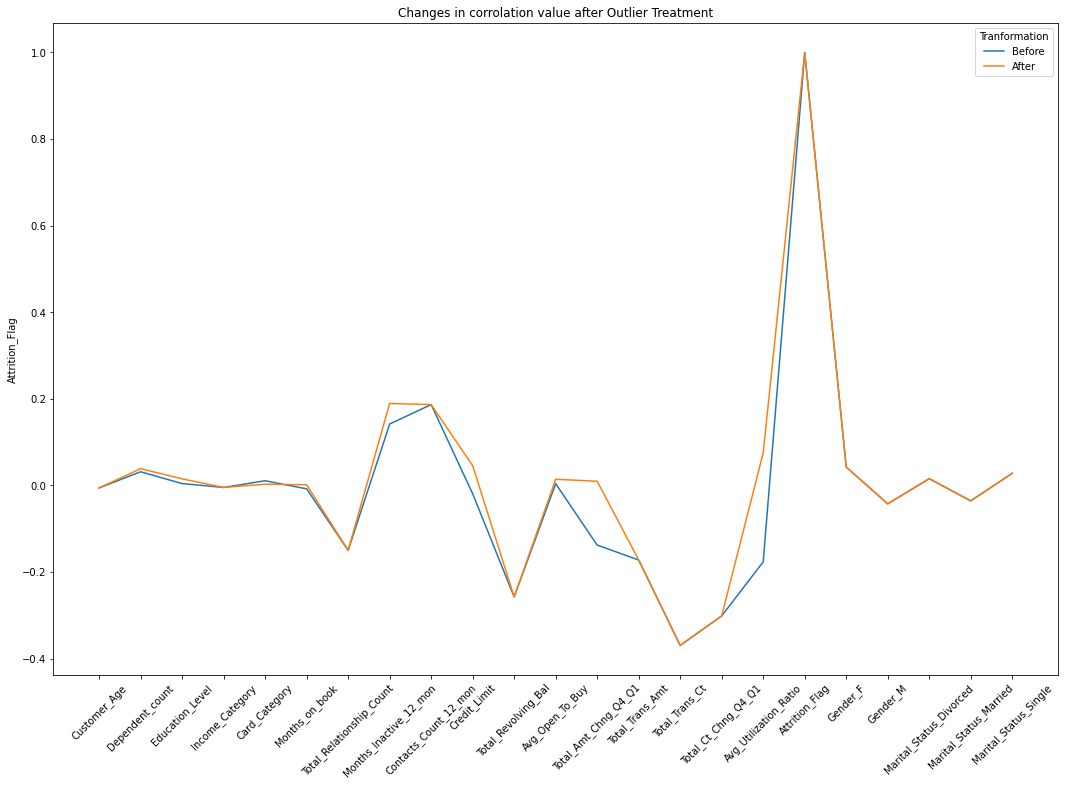

In [46]:
fig, ax = plt.subplots(figsize=(18, 12))

ax = sns.lineplot(data=df, x="index", y=TARGET_COLUMN, hue="Tranformation", ax=ax)
ax.set(title='Changes in corrolation value after Outlier Treatment')
ax.set(xlabel=None)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [47]:
main_data = TreatUoutliers(main_data)

### Pair Plot and Dropping Variables with high Variance and Very low corrolation

In [48]:
# drop features with corrolation of less than 0.05 to the tagert variable
list_of_features_to_drop = main_data.corr()[abs(main_data.corr()[TARGET_COLUMN]) < 0.05].index.to_list()
main_data.drop(list_of_features_to_drop, axis=1, inplace=True)
info(main_data)

5063 Rows x 9 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,5063,0.00%,int8
Avg_Utilization_Ratio,0,5063,0.00%,float64
Contacts_Count_12_mon,0,5063,0.00%,int64
Months_Inactive_12_mon,0,5063,0.00%,float64
Total_Ct_Chng_Q4_Q1,0,5063,0.00%,float64
Total_Relationship_Count,0,5063,0.00%,int64
Total_Revolving_Bal,0,5063,0.00%,int64
Total_Trans_Amt,0,5063,0.00%,int64
Total_Trans_Ct,0,5063,0.00%,int64


In [49]:
main_data.head(10)

,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
4044,3,1.0,4,0,4844,58,0.871,0.276549,0
3777,5,2.0,3,1732,3996,65,0.548,0.150000,0
1878,3,4.0,4,0,1041,27,0.350,0.276549,1
6933,3,3.0,3,1804,4682,90,0.667,0.276549,0
6218,4,2.0,3,0,2493,42,0.500,0.276549,1
719,6,3.0,2,1902,1241,22,1.000,0.246000,0
1175,5,3.0,4,1492,1679,32,0.455,0.317000,0
4712,4,3.0,1,0,3737,71,0.614,0.276549,0
3876,5,2.0,0,1639,4959,74,0.805,0.047000,0
777,4,2.0,0,2035,1770,47,0.741,0.276549,0


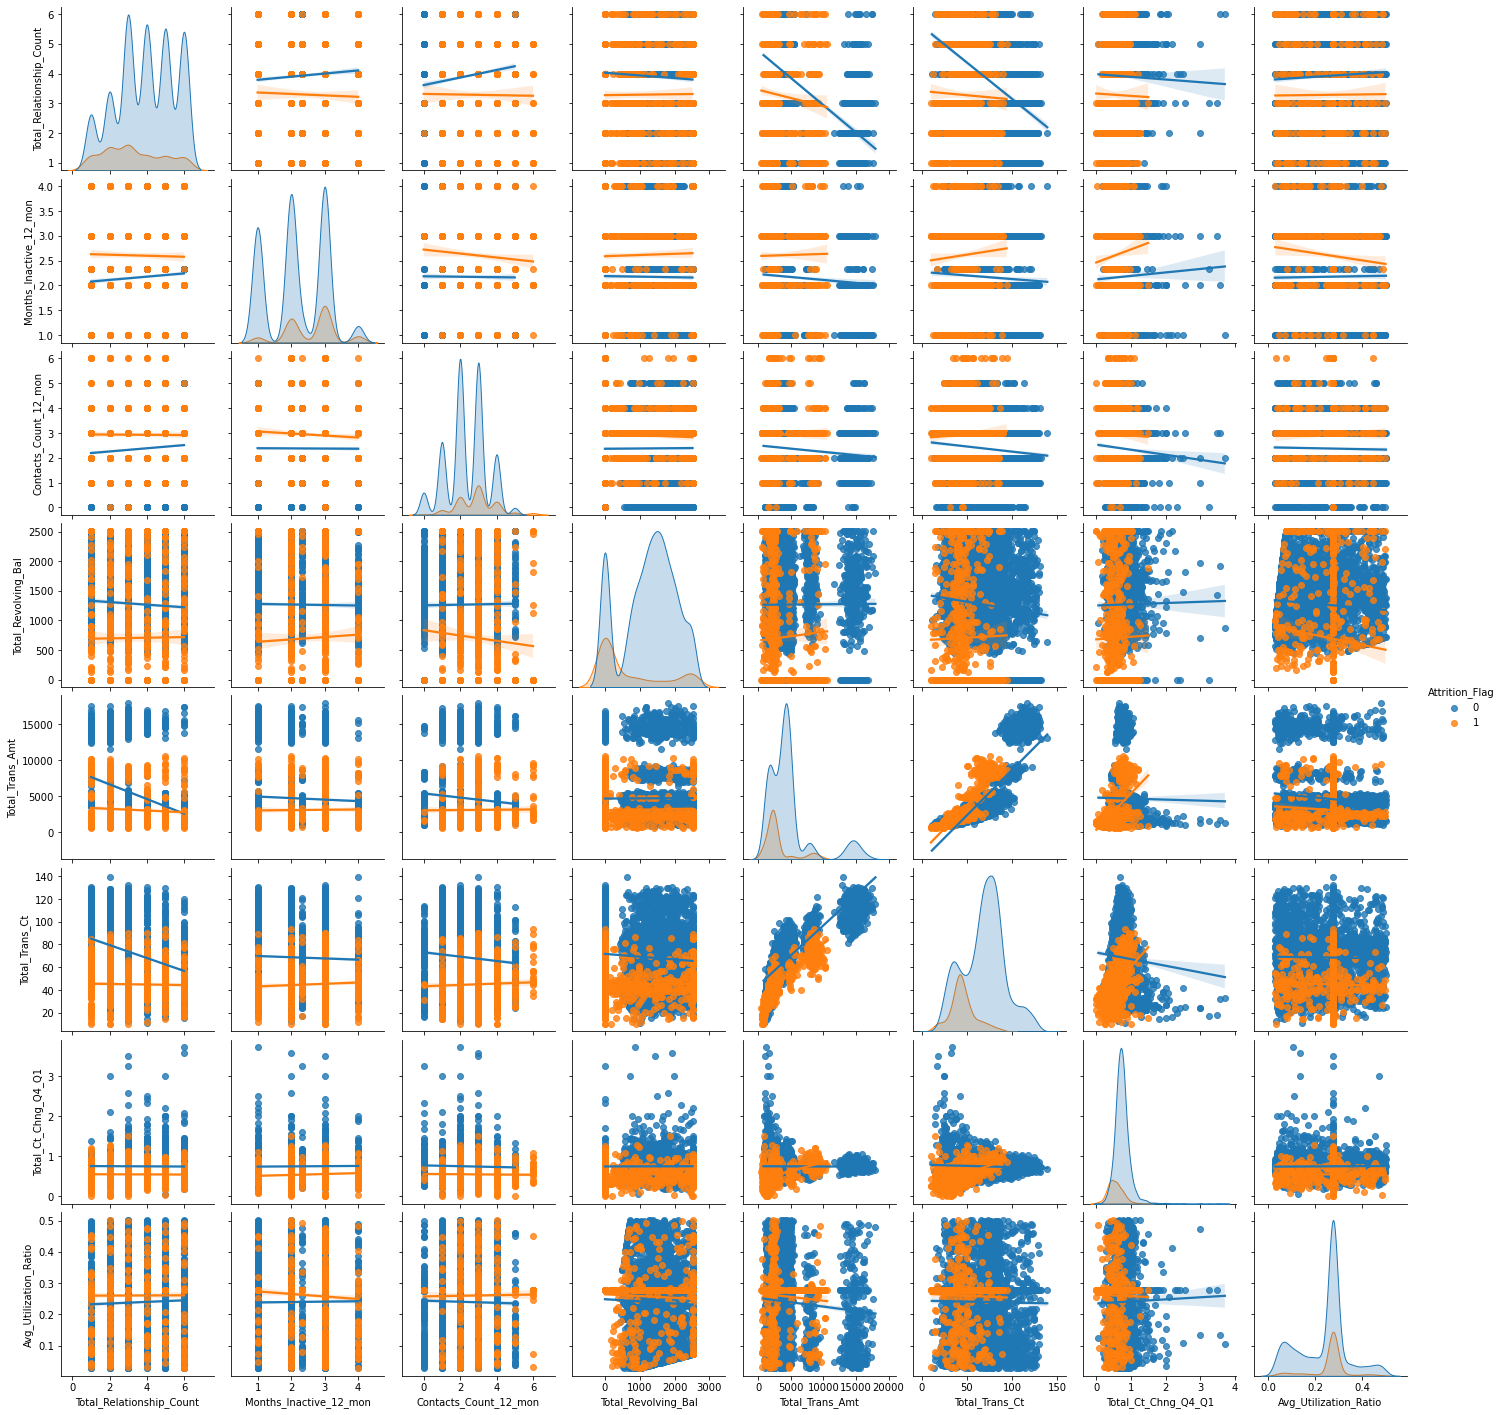

In [50]:
sns.pairplot(main_data, kind="reg", hue=TARGET_COLUMN)

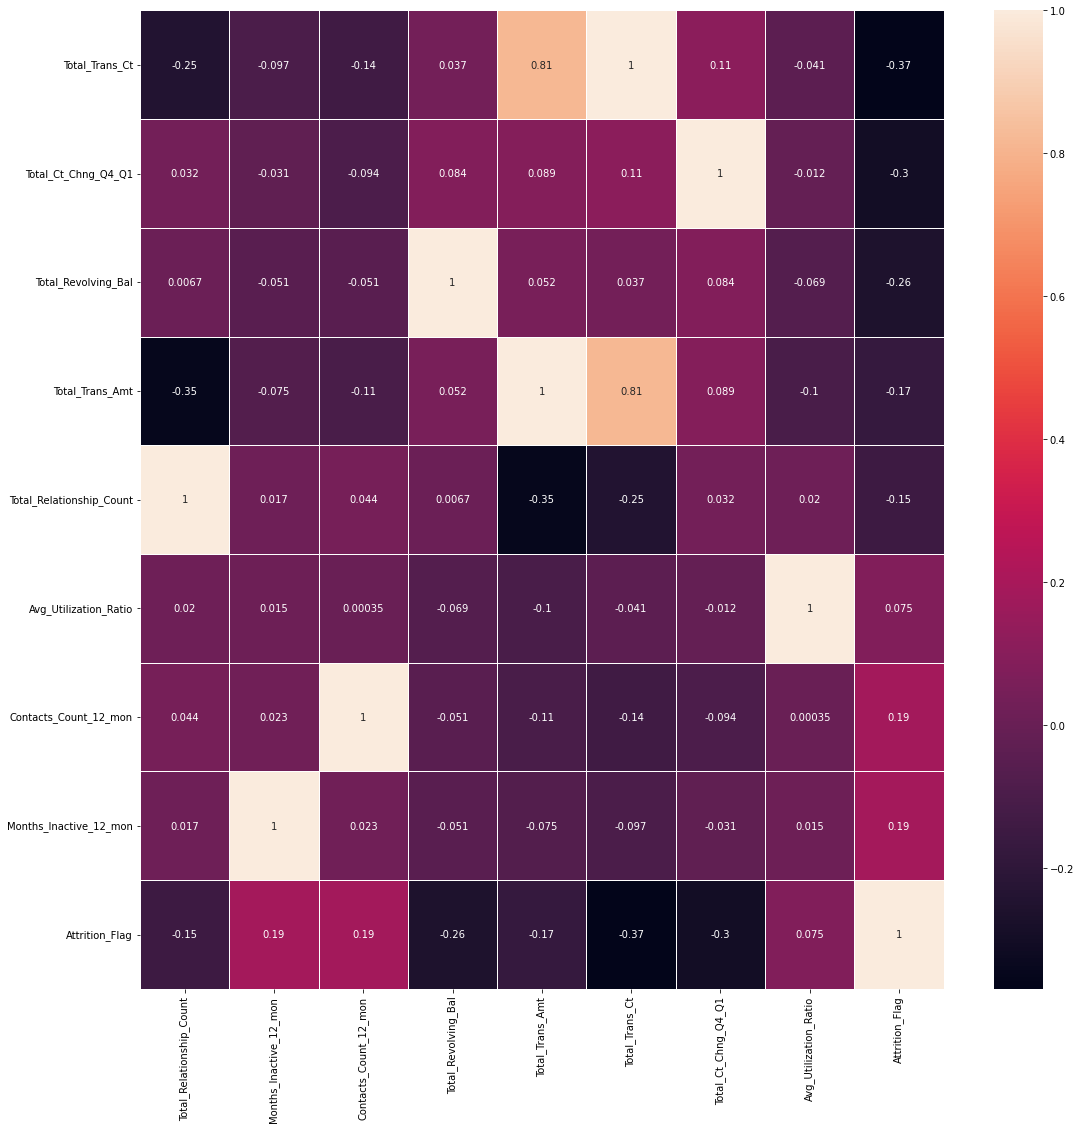

In [51]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=main_data.corr().sort_values(by=[TARGET_COLUMN]), annot=True, linewidths=.5, ax=ax)
plt.show()

####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 4. Model Building and Evaluations

In [52]:
X_2 = main_data.drop([TARGET_COLUMN], axis = 1)
Y_2 = main_data[TARGET_COLUMN]

x_train, x_val, y_train, y_val = train_test_split(X_2, Y_2, test_size=0.5, random_state=1)

print(x_train.shape, x_test.shape)

(2531, 8) (5064, 19)


### Building Models with default values
- The RandomForestClaffier model perfoms better (recall and F1 score) than all other models in most of the labs ran.
- We select the RandomForest model to create the pipeline.

In [53]:
def BuildAndGetModels(x_var, y_var):
    bagging_estimator=BaggingClassifier(random_state=1)
    bagging_estimator.fit(x_var, y_var)
    pprint.pprint(bagging_estimator)
    
    rf_estimator=RandomForestClassifier(random_state=1)
    rf_estimator.fit(x_var, y_var)
    pprint.pprint(rf_estimator)

    logistic_reg_model = LogisticRegression()
    logistic_reg_model.fit(x_var, y_var)
    pprint.pprint(logistic_reg_model)

    dtree1 = DecisionTreeClassifier(random_state=1)
    dtree1.fit(x_var, y_var)
    pprint.pprint(dtree1)

    adaBoosting_Model = AdaBoostClassifier(random_state=1)
    adaBoosting_Model.fit(x_var, y_var)
    pprint.pprint(adaBoosting_Model)

    gradientboost_model = GradientBoostingClassifier(random_state=1)
    gradientboost_model.fit(x_var, y_var)
    pprint.pprint(gradientboost_model)

    models = {
        'Bagging Classifier'        : bagging_estimator,
        'RandomForest Model'        : rf_estimator,
        'Logistic Regression Model' : logistic_reg_model,
        'Decision Tree'             : dtree1,
        'Gradient Boost'            : gradientboost_model,
        'AdaBoostClassifier'        : adaBoosting_Model
    }
    
    return models

In [54]:
def DisplayCoefficients(models, x_var):
    for model_name in models:        
        coefs = pd.DataFrame(
            np.append(models[model_name].coef_, models[model_name].intercept_),
            index=x_var.columns.tolist() + ["Intercept"],
            columns=["Coefficients"],
        )

        print(coefs.sort_values('Coefficients'))

In [55]:
def GetModelsScoreDataFrame(models, x_train_var, x_test_var, y_train_var, y_test_var):
    scores = None
    for model_name in models:
        scores = GetMetricsScore(models[model_name], x_train_var, x_test_var, y_train_var, y_test_var)
        print(f"{model_name}")
    scores_overview_df = pd.DataFrame(columns=scores.keys())

    for model_name in models:
        scores = GetMetricsScore(models[model_name], x_train_var, x_test_var, y_train_var, y_test_var)
        scores_overview_df.loc[model_name] = scores

    return scores_overview_df

In [56]:
models = BuildAndGetModels(x_train, y_train)
pprint.pprint(models)

BaggingClassifier(random_state=1)
RandomForestClassifier(random_state=1)
LogisticRegression()
DecisionTreeClassifier(random_state=1)
AdaBoostClassifier(random_state=1)
GradientBoostingClassifier(random_state=1)
{'AdaBoostClassifier': AdaBoostClassifier(random_state=1),
 'Bagging Classifier': BaggingClassifier(random_state=1),
 'Decision Tree': DecisionTreeClassifier(random_state=1),
 'Gradient Boost': GradientBoostingClassifier(random_state=1),
 'Logistic Regression Model': LogisticRegression(),
 'RandomForest Model': RandomForestClassifier(random_state=1)}


In [57]:
results = GetModelsScoreDataFrame(models, x_train, x_val, y_train, y_val)
results.head()

Bagging Classifier
RandomForest Model
Logistic Regression Model
Decision Tree
Gradient Boost
AdaBoostClassifier


,Accuracy_Test,Accuracy_Train,Recall_Test,Recall_Train,Precision_Test,Precision_Train,F1_Score_Train,F1_Score_Test
Bagging Classifier,0.951817,0.994469,0.812796,0.970874,0.888601,0.995025,0.982801,0.849010
RandomForest Model,0.954186,1.000000,0.803318,1.000000,0.911290,1.000000,1.000000,0.853904
Logistic Regression Model,0.878752,0.881865,0.426540,0.424757,0.734694,0.738397,0.539291,0.539730
Decision Tree,0.922591,1.000000,0.789100,1.000000,0.756818,1.000000,1.000000,0.772622
Gradient Boost,0.956556,0.977084,0.810427,0.895631,0.919355,0.960938,0.927136,0.861461


####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 5. Model building - Oversampled data

In [58]:
sm = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=1)
x_train_over, y_train_over = sm.fit_resample(x_train, y_train)

def BuildAndGetModels(x_var, y_var):
    bagging_estimator=BaggingClassifier(random_state=1)
    bagging_estimator.fit(x_var, y_var)
    pprint.pprint(bagging_estimator)
    
    rf_estimator=RandomForestClassifier(random_state=1)
    rf_estimator.fit(x_var, y_var)
    pprint.pprint(rf_estimator)

    logistic_reg_model = LogisticRegression()
    logistic_reg_model.fit(x_var, y_var)
    pprint.pprint(logistic_reg_model)

    dtree1 = DecisionTreeClassifier(random_state=1)
    dtree1.fit(x_var, y_var)
    pprint.pprint(dtree1)

    adaBoosting_Model = AdaBoostClassifier(random_state=1)
    adaBoosting_Model.fit(x_var, y_var)
    pprint.pprint(adaBoosting_Model)

    gradientboost_model = GradientBoostingClassifier(random_state=1)
    gradientboost_model.fit(x_var, y_var)
    pprint.pprint(gradientboost_model)

    models = {
        'Bagging Classifier'        : bagging_estimator,
        'RandomForest Model'        : rf_estimator,
        'Logistic Regression Model' : logistic_reg_model,
        'Decision Tree'             : dtree1,
        'Gradient Boost'            : gradientboost_model,
        'AdaBoostClassifier'        : adaBoosting_Model
    }
    
    return models

In [59]:
models = BuildAndGetModels(x_train_over, y_train_over)
pprint.pprint(models)

BaggingClassifier(random_state=1)
RandomForestClassifier(random_state=1)
LogisticRegression()
DecisionTreeClassifier(random_state=1)
AdaBoostClassifier(random_state=1)
GradientBoostingClassifier(random_state=1)
{'AdaBoostClassifier': AdaBoostClassifier(random_state=1),
 'Bagging Classifier': BaggingClassifier(random_state=1),
 'Decision Tree': DecisionTreeClassifier(random_state=1),
 'Gradient Boost': GradientBoostingClassifier(random_state=1),
 'Logistic Regression Model': LogisticRegression(),
 'RandomForest Model': RandomForestClassifier(random_state=1)}


In [60]:
results = GetModelsScoreDataFrame(models, x_train, x_val, y_train, y_val)
results.head()

Bagging Classifier
RandomForest Model
Logistic Regression Model
Decision Tree
Gradient Boost
AdaBoostClassifier


,Accuracy_Test,Accuracy_Train,Recall_Test,Recall_Train,Precision_Test,Precision_Train,F1_Score_Train,F1_Score_Test
Bagging Classifier,0.943918,0.995259,0.836493,0.978155,0.828638,0.992611,0.985330,0.832547
RandomForest Model,0.960900,1.000000,0.855450,1.000000,0.904762,1.000000,1.000000,0.879415
Logistic Regression Model,0.872433,0.869617,0.613744,0.616505,0.618138,0.596244,0.606205,0.615933
Decision Tree,0.926935,1.000000,0.834123,1.000000,0.753747,1.000000,1.000000,0.791901
Gradient Boost,0.956951,0.975899,0.850711,0.910194,0.886420,0.939850,0.924784,0.868198


####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 6. Model building - Undersampled data

In [61]:

rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
x_train_un, y_train_un = rus.fit_resample(x_train, y_train)

def BuildAndGetModels(x_var, y_var):
    bagging_estimator=BaggingClassifier(random_state=1)
    bagging_estimator.fit(x_var, y_var)
    pprint.pprint(bagging_estimator)
    
    rf_estimator=RandomForestClassifier(random_state=1)
    rf_estimator.fit(x_var, y_var)
    pprint.pprint(rf_estimator)

    logistic_reg_model = LogisticRegression()
    logistic_reg_model.fit(x_var, y_var)
    pprint.pprint(logistic_reg_model)

    dtree1 = DecisionTreeClassifier(random_state=1)
    dtree1.fit(x_var, y_var)
    pprint.pprint(dtree1)

    adaBoosting_Model = AdaBoostClassifier(random_state=1)
    adaBoosting_Model.fit(x_var, y_var)
    pprint.pprint(adaBoosting_Model)

    gradientboost_model = GradientBoostingClassifier(random_state=1)
    gradientboost_model.fit(x_var, y_var)
    pprint.pprint(gradientboost_model)

    models = {
        'Bagging Classifier'        : bagging_estimator,
        'RandomForest Model'        : rf_estimator,
        'Logistic Regression Model' : logistic_reg_model,
        'Decision Tree'             : dtree1,
        'Gradient Boost'            : gradientboost_model,
        'AdaBoostClassifier'        : adaBoosting_Model
    }
    
    return models

In [62]:
models = BuildAndGetModels(x_train_un, y_train_un)
pprint.pprint(models)

BaggingClassifier(random_state=1)
RandomForestClassifier(random_state=1)
LogisticRegression()
DecisionTreeClassifier(random_state=1)
AdaBoostClassifier(random_state=1)
GradientBoostingClassifier(random_state=1)
{'AdaBoostClassifier': AdaBoostClassifier(random_state=1),
 'Bagging Classifier': BaggingClassifier(random_state=1),
 'Decision Tree': DecisionTreeClassifier(random_state=1),
 'Gradient Boost': GradientBoostingClassifier(random_state=1),
 'Logistic Regression Model': LogisticRegression(),
 'RandomForest Model': RandomForestClassifier(random_state=1)}


In [63]:
results = GetModelsScoreDataFrame(models, x_train, x_val, y_train, y_val)
results.head()

Bagging Classifier
RandomForest Model
Logistic Regression Model
Decision Tree
Gradient Boost
AdaBoostClassifier


,Accuracy_Test,Accuracy_Train,Recall_Test,Recall_Train,Precision_Test,Precision_Train,F1_Score_Train,F1_Score_Test
Bagging Classifier,0.921801,0.936784,0.921801,0.980583,0.702166,0.726619,0.834711,0.797131
RandomForest Model,0.929305,0.933228,0.943128,1.000000,0.719711,0.709122,0.829809,0.816410
Logistic Regression Model,0.814376,0.805610,0.815166,0.817961,0.467391,0.446950,0.578045,0.594128
Decision Tree,0.874803,0.909127,0.900474,1.000000,0.580153,0.641745,0.781784,0.705664
Gradient Boost,0.929305,0.938364,0.933649,0.990291,0.722936,0.728571,0.839506,0.814891


####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 7. Hyperparameter tuning using random search

In [64]:
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(x_train, y_train)
pprint.pprint(bagging_estimator)

parameters = {
    'max_samples'  : [0.7, 0.8, 0.9, 1],
    'max_features' : [0.7, 0.8, 0.9, 1],
    'n_estimators' : [10, 20, 30, 40, 50]
}

acc_scorer = metrics.make_scorer(metrics.recall_score)
scorer = metrics.make_scorer(metrics.recall_score)
grid_obj = RandomizedSearchCV(
    estimator=bagging_estimator,
    param_distributions=parameters,
    n_jobs=-1,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

gird_obj = grid_obj.fit(x_train_over,y_train_over)
bagging_estimator = grid_obj.best_estimator_
bagging_estimator.fit(x_train_over,y_train_over)

BaggingClassifier(random_state=1)


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=40,
                  random_state=1)

In [65]:
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(x_train, y_train)
pprint.pprint(rf_estimator)

parameters = {
    'class_weight'      : [{0: 0.3, 1: 0.7}],
    'min_samples_leaf'  : np.arange(5, 10),
    'max_features'      : np.arange(0.2,0.7, 0.1),
    'max_samples'       : np.arange(0.3, 0.7, 0.1),
    "n_estimators"      : [100, 150, 200, 250]
}

acc_scorer = metrics.make_scorer(metrics.recall_score)
scorer = metrics.make_scorer(metrics.recall_score)
grid_obj = RandomizedSearchCV(
    estimator=rf_estimator,
    param_distributions=parameters,
    n_jobs=-1,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

gird_obj = grid_obj.fit(x_train_over,y_train_over)
rf_estimator = grid_obj.best_estimator_
rf_estimator.fit(x_train_over,y_train_over)

RandomForestClassifier(random_state=1)


RandomForestClassifier(class_weight={0: 0.3, 1: 0.7},
                       max_features=0.5000000000000001, max_samples=0.5,
                       min_samples_leaf=6, random_state=1)

In [66]:
dtree1 = DecisionTreeClassifier(random_state=1)
dtree1.fit(x_train, y_train)
pprint.pprint(dtree1)

DecisionTreeClassifier(random_state=1)


In [67]:
adaBoosting_Model = AdaBoostClassifier(random_state=1)
adaBoosting_Model.fit(x_train, y_train)
pprint.pprint(adaBoosting_Model)

parameters = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

acc_scorer = metrics.make_scorer(metrics.recall_score)
scorer = metrics.make_scorer(metrics.recall_score)
grid_obj = RandomizedSearchCV(
    estimator=adaBoosting_Model,
    param_distributions=parameters,
    n_jobs=-1,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

gird_obj = grid_obj.fit(x_train_over,y_train_over)
adaBoosting_Model = grid_obj.best_estimator_
adaBoosting_Model.fit(x_train_over,y_train_over)

AdaBoostClassifier(random_state=1)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1, n_estimators=90, random_state=1)

In [68]:
gradientboost_model = GradientBoostingClassifier(random_state=1)
gradientboost_model.fit(x_train, y_train)
pprint.pprint(gradientboost_model)

parameters = {
    "subsample"       : [0.8, 0.9, 1],
    "n_estimators"    : [100, 150, 250],
    "max_features"    : [0.7, 0.8, 0.9, 1]
}


acc_scorer = metrics.make_scorer(metrics.recall_score)
scorer = metrics.make_scorer(metrics.recall_score)
grid_obj = RandomizedSearchCV(
    estimator=gradientboost_model,
    param_distributions=parameters,
    n_jobs=-1,
    n_iter=20,
    scoring=scorer,
    cv=5,
    random_state=1,
)

gird_obj = grid_obj.fit(x_train_over,y_train_over)
gradientboost_model = grid_obj.best_estimator_
gradientboost_model.fit(x_train_over,y_train_over)

GradientBoostingClassifier(random_state=1)


GradientBoostingClassifier(max_features=0.9, n_estimators=250, random_state=1,
                           subsample=1)

In [69]:
models = {
    'Bagging Classifier'        : bagging_estimator,
    'RandomForest Model'        : rf_estimator,
    'Decision Tree'             : dtree1,
    'Gradient Boost'            : gradientboost_model,
    'AdaBoostClassifier'        : adaBoosting_Model
}

In [70]:
results = GetModelsScoreDataFrame(models, x_train, x_val, y_train, y_val)
results.head()

Bagging Classifier
RandomForest Model
Decision Tree
Gradient Boost
AdaBoostClassifier


,Accuracy_Test,Accuracy_Train,Recall_Test,Recall_Train,Precision_Test,Precision_Train,F1_Score_Train,F1_Score_Test
Bagging Classifier,0.951422,0.999605,0.853081,0.997573,0.855107,1.000000,0.998785,0.854093
RandomForest Model,0.948262,0.957724,0.898104,0.927184,0.811563,0.832244,0.877153,0.852643
Decision Tree,0.922591,1.000000,0.789100,1.000000,0.756818,1.000000,1.000000,0.772622
Gradient Boost,0.961295,0.989332,0.862559,0.966019,0.900990,0.968370,0.967193,0.881356
AdaBoostClassifier,0.948657,0.993678,0.848341,0.987864,0.844340,0.973684,0.980723,0.846336


####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 9. Pipeline

### Custom Transformation Classes

In [71]:
'''
Input:
Target type and a list of feature names.

Output:
Convert all features provided in 'column_names' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''      
class ConvertObjectToCategoryType(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        catgry_col_names = x_dataset.select_dtypes(include=['object']).columns.tolist()
        for col_name in catgry_col_names:
            x_dataset[col_name] = x_dataset[col_name].astype("category")
        
        return x_dataset
    
class FixOutliers(BaseEstimator):

    def __init__(self, y):
        self.y = y
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        columns = x_dataset.select_dtypes(include=['float', 'int64']).columns.tolist()
        for column in columns:
            x_dataset[column] = BestCorrOutlierTreatment(column, TARGET_COLUMN, pd.concat([x_dataset, pd.Series(self.y, name=TARGET_COLUMN)], axis=1).reset_index())
        return x_dataset
    
class ReplaceMissingCatgrValues(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        x_dataset['Education_Level'].fillna(x_dataset['Education_Level'].value_counts().idxmax(), inplace=True)
        x_dataset['Marital_Status'].fillna(x_dataset['Marital_Status'].value_counts().idxmax(), inplace=True)
        return x_dataset
    
class ReplaceFeatureValuesWithIntValues(BaseEstimator):

    def __init__(self, y):
        self.y = y
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        replace_struct = {
            "Card_Category"       : {"Blue": 1, "Silver": 2, "good": 3, "Gold": 4, "Platinum": 5},
            "Income_Category"     : {"abc": -1, "Less than $40K": 1, "$40K - $60K": 2, "$60K - $80K": 3, "$80K - $120K": 4, "$120K +": 5},
            "Education_Level"     : {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4, "Post-Graduate":5, "Doctorate": 6},
        }
        x_dataset =  x_dataset.replace(replace_struct)
        return x_dataset
    
class DropColumns(BaseEstimator):

    def __init__(self, y):
        self.y = y
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        df = pd.concat([x_dataset, self.y], axis=1).reset_index()
        list_of_features_to_drop = df.corr()[abs(df.corr()[TARGET_COLUMN]) < 0.05].index.to_list()
        df.drop(list_of_features_to_drop, axis=1, inplace=True)
        x_dataset =  df.drop([TARGET_COLUMN], axis = 1)
        return x_dataset
    
class DummyClassifier(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        return x_dataset

### Build The pipeline

In [72]:
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
x_train_un, y_train_un = rus.fit_resample(x_test, y_test)

#### Build Pipeline on Training Data

In [73]:
pipeline = Pipeline([
    ('Fix_Columns_Types', ConvertObjectToCategoryType()),
    ('Missing_Values', ReplaceMissingCatgrValues()),
    ('Column_Transformation', ReplaceFeatureValuesWithIntValues(y_test)),
    ('OneHotEncoding', ce.OneHotEncoder(cols=["Gender", "Marital_Status"], use_cat_names=True)),
    ('Outlier_Treatment', FixOutliers(y_train_un)),
    ('make_target_int', ConvertObjectToCategoryType()),
    ('Drop_Features', DropColumns(y_train_un)),
    ('clsf', RandomForestClassifier(random_state=1))
])

In [74]:
pipeline.fit(x_train_un, y_train_un)
pipeline.score(x_train_un, y_train_un)

1.0

#### Build Pipeline on Test Data

In [75]:
pipeline = Pipeline([
    ('Fix_Columns_Types', ConvertObjectToCategoryType()),
    ('Missing_Values', ReplaceMissingCatgrValues()),
    ('Column_Transformation', ReplaceFeatureValuesWithIntValues(y_test)),
    ('OneHotEncoding', ce.OneHotEncoder(cols=["Gender", "Marital_Status"], use_cat_names=True)),
    ('Outlier_Treatment', FixOutliers(y_test)),
    ('make_target_int', ConvertObjectToCategoryType()),
    ('Drop_Features', DropColumns(y_test)),
    ('clsf', RandomForestClassifier(random_state=1))
])

In [76]:
pipeline.fit(x_test, y_test)
pipeline.score(x_test, y_test)

0.9992101105845181

####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 10. Recommendations


- Attrition_Flag, Avg_Utilization_Ratio, Contacts_Count_12_mon, Months_Inactive_12_mon, Total_Ct_Chng_Q4_Q1, Total_Relationship_Count, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct, these are the most important features to predict whether a customer will abondon the service or not.
- The number of clients is higher in customers who are Graduates
- The number of clients is higher in customers who are Married and Single
- The number of clients is higher in customers who earn less that 40k per year
- Blue card has the highest number of clients and seems to be the one brining in more money
- The charts sho a higher number of clients who are married and single
- Also the ratio of clients who left the service based on marital statis seems insignificance. Cannot deduce from the current of the data who category is most likely to stay or leave.
- Another noticeable difference is how dominant maried category is.
- Also most of the customers seems to be having a 2-3 dependents 
- The charts sho a higher number of clients who are married and single
- Also the ratio of clients who left the service based on marital statis seems insignificance. Cannot deduce from the current of the data who category is most likely to stay or leave.
- Another noticeable difference is how dominant maried category is.
- Also most of the customers seems to be having a 2-3 dependents 
- Again we see blue as the most dominant card in all categories.
- This blue card is also the one with the highest number of attrited customers.
- There is also a higher number of customers using the blue card who are earning less than 40k per year.
- We notice a spike or peak values in customers who are earning less than 40k per year
- The number of people leaving the credit card service based on income seems level or average accross all categories except for customers who are earning less than 40k per year with the highest number of attrition
- Customers who earn less than  40k per year also have 2-3 dependants
- The RandomForestClaffier model perfoms better (recall and F1 score) than all other models in most of the labs ran.
- We select the RandomForest model to create the pipeline.
- Suggestions are:
    - Look for programs to improve Avg_Utilization_Ratio
    - The lower the Total_Revolving_Bal, the more chances of increeasing attrition
    - decrease in Total_Trans_Ct means increase in retension, look for ways to help customers better use their cards less.